<a href="https://colab.research.google.com/github/lucacamus13/Tesis/blob/main/Limpieza_de_datos_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Primero instalar las librerías necesarias
!pip install pandas numpy yfinance fredapi matplotlib seaborn

FRED API KEY: 73be39590b688a9ca91a02451eed4cc5

# Obtención de variables macro

-FF4: intradia (se suman), es la apuesta del mercado a cuál será la tasa de interés dentro de un trimestre. mide el "Path Shock" (Trayectoria/Forward Guidance): La sorpresa sobre lo que la FED hará en el futuro cercano.

-FF1: intradia, mide el "Target Shock": La sorpresa sobre lo que la FED hizo hoy. (Ej: El mercado esperaba subida de 25bps y la FED subió 25bps. Sorpresa = 0).

-PCEPI: mensual, índice, mide los cambios en los precios de bienes y servicios consumidos por hogares.

-INDPRO: mensual, índice, mide volumen de producción de la industria.

-RBUSBIS: mensual, índice, mide el valor promedio del dólar respecto a una canasta de otras monedas.

In [18]:
import pandas as pd
from fredapi import Fred
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# Configuración de Estilo
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

def extract_fred_series(api_key='73be39590b688a9ca91a02451eed4cc5'):
    """
    Extraer series específicas de FRED y combinarlas en un DataFrame.
    Se ha eliminado FEDFUNDS de esta lista.
    """
    print("📊 EXTRAYENDO SERIES DE FRED")
    print("="*40)

    # Inicializar FRED API
    fred = Fred(api_key=api_key)

    # Series a extraer (FEDFUNDS ELIMINADO)
    series_codes = {
        'PCEPI': 'PCE Price Index',
        'INDPRO': 'Industrial Production Index',
        'RBUSBIS': 'Real Broad US Dollar Index'
    }

    # DataFrame para almacenar todas las series
    df = pd.DataFrame()

    # Extraer cada serie
    for code, description in series_codes.items():
        try:
            print(f"📈 Extrayendo {code} - {description}...")
            series = fred.get_series(code)

            if not series.empty:
                df[code] = series
                print(f"   ✅ {len(series)} observaciones desde {series.index.min().date()} hasta {series.index.max().date()}")
            else:
                print(f"   ⚠️ Sin datos para {code}")

        except Exception as e:
            print(f"   ❌ Error con {code}: {e}")

    # Resamplear a inicio de mes para asegurar consistencia
    if not df.empty:
        df = df.resample('MS').first()

    return df

def process_monetary_shocks():
    """
    Procesar las variables de Shock FF4 y FF1 desde GitHub
    Fuente: Acosta (2022) / GSS
    Hoja: "Monetary Events"
    Columnas:
        - B (date_time)
        - K (FF4)
        - H (FF1)
    Metodología: Suma mensual de eventos intradía. Rellenar NaNs con 0.
    """
    print("\n⚡ PROCESANDO SHOCKS DE POLÍTICA MONETARIA (FF4 y FF1)")
    print("="*40)

    # URL Raw para descarga directa
    url = "https://github.com/lucacamus13/Tesis/raw/main/data/USMPD-FF4%20EEUU.xlsx"

    try:
        print(f"📥 Descargando datos desde: {url}")
        # Leer archivo Excel especificando la hoja
        df = pd.read_excel(url, sheet_name='Monetary Events')

        # Normalizar nombres de columnas
        df.columns = [str(col).strip() for col in df.columns]

        # Identificar columnas específicas
        date_col = None
        ff4_col = None
        ff1_col = None

        # Búsqueda por nombre
        for col in df.columns:
            col_lower = col.lower()
            if 'date_time' in col_lower:
                date_col = col
            if 'ff4' in col_lower and 'ff4' == col.split()[0].lower():
                ff4_col = col
            if 'ff1' in col_lower and 'ff1' == col.split()[0].lower():
                ff1_col = col

        # Fallback por posición (B=1, H=7, K=10)
        if date_col is None and len(df.columns) > 1:
             date_col = df.columns[1]
             print(f"   ⚠️ No se encontró 'date_time', usando columna índice 1: {date_col}")

        if ff1_col is None and len(df.columns) > 7:
             ff1_col = df.columns[7]
             print(f"   ⚠️ No se encontró 'FF1', usando columna índice 7: {ff1_col}")

        if ff4_col is None:
            # Buscar cualquier columna que contenga FF4
            candidates = [c for c in df.columns if 'ff4' in c.lower()]
            if candidates:
                ff4_col = candidates[0]
            elif len(df.columns) > 10:
                ff4_col = df.columns[10]
                print(f"   ⚠️ No se encontró 'FF4', usando columna índice 10: {ff4_col}")

        if date_col is None:
            raise ValueError("No se pudo identificar la columna de fecha.")

        print(f"   📅 Fecha: {date_col}")
        print(f"   🎯 FF4:   {ff4_col}")
        print(f"   🎯 FF1:   {ff1_col}")

        # Convertir fecha
        df[date_col] = pd.to_datetime(df[date_col])
        df = df.set_index(date_col)

        # Seleccionar y renombrar
        cols_to_extract = {}
        if ff4_col: cols_to_extract[ff4_col] = 'FF4'
        if ff1_col: cols_to_extract[ff1_col] = 'FF1'

        shock_series = df[list(cols_to_extract.keys())].copy()
        shock_series = shock_series.rename(columns=cols_to_extract)

        # Asegurar numérico
        for col in shock_series.columns:
            shock_series[col] = pd.to_numeric(shock_series[col], errors='coerce')

        # Agrupación Mensual (Suma)
        print("   🔄 Agrupando datos a frecuencia MENSUAL (Suma)...")
        shock_monthly = shock_series.resample('MS').sum()

        # Rellenar meses sin datos con 0.0
        full_idx = pd.date_range(start=shock_monthly.index.min(),
                               end=shock_monthly.index.max(),
                               freq='MS')

        shock_final = shock_monthly.reindex(full_idx).fillna(0.0)

        print(f"   ✅ Procesamiento completado. {len(shock_final)} observaciones.")
        for col in shock_final.columns:
            non_zero = (shock_final[col] != 0).sum()
            print(f"   ℹ️ {col}: {non_zero} meses con shock != 0")

        return shock_final

    except Exception as e:
        print(f"   ❌ Error procesando Shocks: {e}")
        return None

def auditar_serie(df, nombre_serie):
    """
    Función para auditar visual y estadísticamente una serie específica.
    Muestra: Gráfico, Histograma, Estadísticas descriptivas y Periodicidad.
    """
    if df is None or nombre_serie not in df.columns:
        print(f"❌ La serie '{nombre_serie}' no se encuentra en el DataFrame.")
        return

    print(f"\n🔍 AUDITORÍA DE LA SERIE: {nombre_serie}")
    print("="*60)

    serie = df[nombre_serie].dropna()

    # 1. Información Básica
    print(f"📌 Rango Temporal: {serie.index.min().date()} a {serie.index.max().date()}")
    print(f"📌 Observaciones: {len(serie)}")

    # Intentar inferir frecuencia
    freq = pd.infer_freq(serie.index)
    print(f"📌 Frecuencia detectada: {freq if freq else 'No detectada (Irregular)'}")

    # 2. Estadísticas Descriptivas
    stats = serie.describe()
    print("\n📊 ESTADÍSTICAS DESCRIPTIVAS:")
    print(f"   - Media:   {stats['mean']:.4f}")
    print(f"   - Desvío:  {stats['std']:.4f}")
    print(f"   - Min:     {stats['min']:.4f}")
    print(f"   - Max:     {stats['max']:.4f}")
    print(f"   - Mediana: {serie.median():.4f}")

    # 3. Gráficos
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Serie de Tiempo
    sns.lineplot(data=serie, ax=axes[0], linewidth=2)
    axes[0].set_title(f"Evolución Histórica: {nombre_serie}")
    axes[0].set_xlabel("Fecha")
    axes[0].set_ylabel("Valor")

    # Histograma / Distribución
    sns.histplot(data=serie, kde=True, ax=axes[1])
    axes[1].set_title(f"Distribución: {nombre_serie}")
    axes[1].set_xlabel("Valor")

    plt.tight_layout()
    plt.show()

def main():
    print("🚀 INICIANDO LIMPIEZA DE DATOS")

    # 1. Datos Macro FRED
    macro_df = extract_fred_series()

    # 2. Datos Shocks (FF4 y FF1)
    shocks_df = process_monetary_shocks()

    # Combinar
    if not macro_df.empty and shocks_df is not None:
        print("\n🔗 COMBINANDO BASES DE DATOS...")
        # Merge por índice (fecha)
        full_df = macro_df.join(shocks_df, how='outer')

        # Recortar al rango donde empiezan los datos de Shocks
        start_date = shocks_df.index.min()
        full_df = full_df.loc[start_date:]

        print(f"   ✅ Base consolidada: {full_df.shape}")

        # Mostrar últimas filas
        print("\n📋 ÚLTIMAS 5 OBSERVACIONES:")
        print(full_df.tail())

        return full_df
    else:
        print("\n⚠️ No se pudo combinar las bases.")
        return None

if __name__ == "__main__":
    df_final = main()



🚀 INICIANDO LIMPIEZA DE DATOS
📊 EXTRAYENDO SERIES DE FRED
📈 Extrayendo PCEPI - PCE Price Index...
   ✅ 801 observaciones desde 1959-01-01 hasta 2025-09-01
📈 Extrayendo INDPRO - Industrial Production Index...
   ✅ 1281 observaciones desde 1919-01-01 hasta 2025-09-01
📈 Extrayendo RBUSBIS - Real Broad US Dollar Index...
   ✅ 383 observaciones desde 1994-01-01 hasta 2025-11-01

⚡ PROCESANDO SHOCKS DE POLÍTICA MONETARIA (FF4 y FF1)
📥 Descargando datos desde: https://github.com/lucacamus13/Tesis/raw/main/data/USMPD-FF4%20EEUU.xlsx
   📅 Fecha: date_time
   🎯 FF4:   FF4
   🎯 FF1:   FF1
   🔄 Agrupando datos a frecuencia MENSUAL (Suma)...
   ✅ Procesamiento completado. 383 observaciones.
   ℹ️ FF4: 209 meses con shock != 0
   ℹ️ FF1: 161 meses con shock != 0

🔗 COMBINANDO BASES DE DATOS...
   ✅ Base consolidada: (383, 5)

📋 ÚLTIMAS 5 OBSERVACIONES:
              PCEPI    INDPRO  RBUSBIS    FF4     FF1
2025-08-01  127.283  101.3300   108.69  0.000  0.0000
2025-09-01  127.625  101.4279   108.26 -0

ANALISIS DE CADA SERIE


🔍 AUDITORÍA DE LA SERIE: FF1
📌 Rango Temporal: 1994-02-01 a 2025-12-01
📌 Observaciones: 383
📌 Frecuencia detectada: MS

📊 ESTADÍSTICAS DESCRIPTIVAS:
   - Media:   -0.0042
   - Desvío:  0.0352
   - Min:     -0.3625
   - Max:     0.1400
   - Mediana: 0.0000


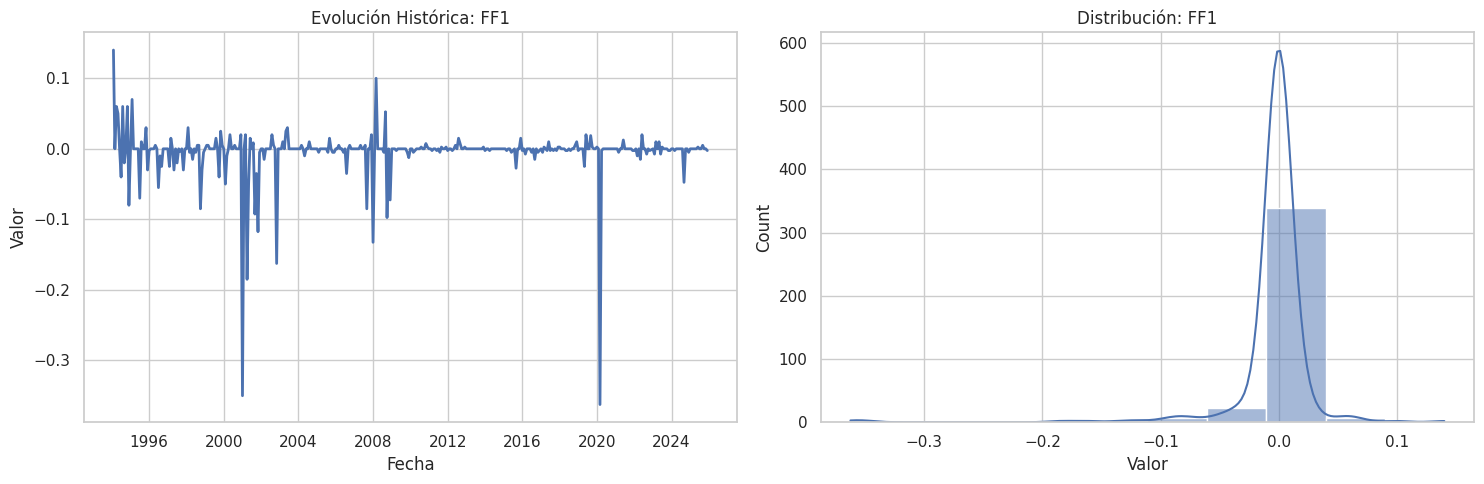

In [19]:
if df_final is not None:
    auditar_serie(df_final, 'FF1')

# Obtención de datos financieros

-S&P500: diario a mensual, último dato del mes. Datos desde 1950

-VIX: diario a mensual, promedio mensual. Datos desde 1990

In [24]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Configuración de Estilo
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

def obtener_financieras():
    """
    Obtener variables financieras desde Yahoo Finance.
    Variables:
    - VIX (^VIX): Volatility Index
    - SP500 (^GSPC): S&P 500 Index

    Metodología:
    - Descarga diaria.
    - Resampleo mensual: Promedio (Mean).
    """
    print("💰 OBTENIENDO VARIABLES FINANCIERAS (Yahoo Finance)")
    print("="*50)

    tickers = {
        '^VIX': 'VIX',
        '^GSPC': 'SP500'
    }

    df_combined = pd.DataFrame()

    for ticker, name in tickers.items():
        try:
            print(f"📉 Descargando {name} ({ticker})...")
            # Descargar historia completa explícitamente
            data = yf.download(ticker, period="max", progress=False)

            if not data.empty:
                # Manejo de columnas de yfinance (puede devolver MultiIndex)
                # Estructura típica: columnas son tuplas ('Close', 'Ticker') o simplemente 'Close'

                # Intentar aplanar si es MultiIndex
                if isinstance(data.columns, pd.MultiIndex):
                    # Si hay nivel 'Ticker', lo bajamos o seleccionamos
                    try:
                        series = data.xs('Close', level=0, axis=1)
                        if series.empty:
                             series = data.xs('Adj Close', level=0, axis=1)
                    except:
                        # Si falla xs, intentar acceso directo si la estructura es distinta
                        if 'Close' in data.columns.get_level_values(0):
                             series = data.iloc[:, data.columns.get_level_values(0) == 'Close']
                        else:
                             series = data.iloc[:, 0] # Fallback
                else:
                    # Índice simple
                    if 'Close' in data.columns:
                        series = data['Close']
                    elif 'Adj Close' in data.columns:
                        series = data['Adj Close']
                    else:
                        series = data.iloc[:, 0]

                # Asegurar que sea Series (si es DataFrame de 1 columna, convertir)
                if isinstance(series, pd.DataFrame):
                    if series.shape[1] == 1:
                        series = series.iloc[:, 0]
                    else:
                        # Si por alguna razón quedan múltiples columnas, tomar la primera
                        series = series.iloc[:, 0]

                print(f"   ✅ {len(series)} observaciones diarias ({series.index.min().date()} - {series.index.max().date()})")

                # Resampleo Mensual (Promedio)
                print(f"   🔄 Mensualizando (Promedio)...")
                series_monthly = series.resample('MS').mean()

                df_combined[name] = series_monthly
            else:
                print(f"   ⚠️ No se encontraron datos para {name}")

        except Exception as e:
            print(f"   ❌ Error descargando {name}: {e}")

    if not df_combined.empty:
        print(f"\n✅ Extracción completada. Rango: {df_combined.index.min().date()} a {df_combined.index.max().date()}")
        return df_combined
    else:
        return None

def auditar_serie(df, nombre_serie):
    """
    Función para auditar visual y estadísticamente una serie específica.
    Muestra: Gráfico, Histograma, Estadísticas descriptivas y Periodicidad.
    """
    if df is None or nombre_serie not in df.columns:
        print(f"❌ La serie '{nombre_serie}' no se encuentra en el DataFrame.")
        return

    print(f"\n🔍 AUDITORÍA DE LA SERIE: {nombre_serie}")
    print("="*60)

    serie = df[nombre_serie].dropna()

    # 1. Información Básica
    print(f"📌 Rango Temporal: {serie.index.min().date()} a {serie.index.max().date()}")
    print(f"📌 Observaciones: {len(serie)}")

    # Intentar inferir frecuencia
    freq = pd.infer_freq(serie.index)
    print(f"📌 Frecuencia detectada: {freq if freq else 'No detectada (Irregular)'}")

    # 2. Estadísticas Descriptivas
    stats = serie.describe()
    print("\n📊 ESTADÍSTICAS DESCRIPTIVAS:")
    print(f"   - Media:   {stats['mean']:.4f}")
    print(f"   - Desvío:  {stats['std']:.4f}")
    print(f"   - Min:     {stats['min']:.4f}")
    print(f"   - Max:     {stats['max']:.4f}")
    print(f"   - Mediana: {serie.median():.4f}")

    # 3. Gráficos
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Serie de Tiempo
    sns.lineplot(data=serie, ax=axes[0], linewidth=2)
    axes[0].set_title(f"Evolución Histórica: {nombre_serie}")
    axes[0].set_xlabel("Fecha")
    axes[0].set_ylabel("Valor")

    # Histograma / Distribución
    sns.histplot(data=serie, kde=True, ax=axes[1])
    axes[1].set_title(f"Distribución: {nombre_serie}")
    axes[1].set_xlabel("Valor")

    plt.tight_layout()
    plt.show()

def main():
    print("🚀 INICIANDO OBTENCIÓN DE VARIABLES FINANCIERAS")

    df_fin = obtener_financieras()

    if df_fin is not None:
        print("\n📋 PRIMERAS 5 FILAS:")
        print(df_fin.head())

        print("\n📋 ÚLTIMAS 5 FILAS:")
        print(df_fin.tail())

        return df_fin
    else:
        print("\n❌ Falló la obtención de datos.")
        return None

if __name__ == "__main__":
    df_resultado = main()



🚀 INICIANDO OBTENCIÓN DE VARIABLES FINANCIERAS
💰 OBTENIENDO VARIABLES FINANCIERAS (Yahoo Finance)
📉 Descargando VIX (^VIX)...
   ✅ 9061 observaciones diarias (1990-01-02 - 2025-12-22)
   🔄 Mensualizando (Promedio)...
📉 Descargando SP500 (^GSPC)...
   ✅ 24611 observaciones diarias (1927-12-30 - 2025-12-22)
   🔄 Mensualizando (Promedio)...

✅ Extracción completada. Rango: 1990-01-01 a 2025-12-01

📋 PRIMERAS 5 FILAS:
                  VIX       SP500
Date                             
1990-01-01  23.347273  339.971818
1990-02-01  23.262632  330.452635
1990-03-01  20.062273  338.465000
1990-04-01  21.403500  338.177998
1990-05-01  18.097727  350.250001

📋 ÚLTIMAS 5 FILAS:
                  VIX        SP500
Date                              
2025-08-01  15.750000  6408.949475
2025-09-01  15.773333  6584.018090
2025-10-01  18.086522  6735.691725
2025-11-01  19.904211  6740.885768
2025-12-01  16.100000  6834.159363


ANALISIS DE CADA SERIE


🔍 AUDITORÍA DE LA SERIE: VIX
📌 Rango Temporal: 1990-01-01 a 2025-12-01
📌 Observaciones: 432
📌 Frecuencia detectada: MS

📊 ESTADÍSTICAS DESCRIPTIVAS:
   - Media:   19.4625
   - Desvío:  7.4144
   - Min:     10.1255
   - Max:     62.6395
   - Mediana: 17.6853


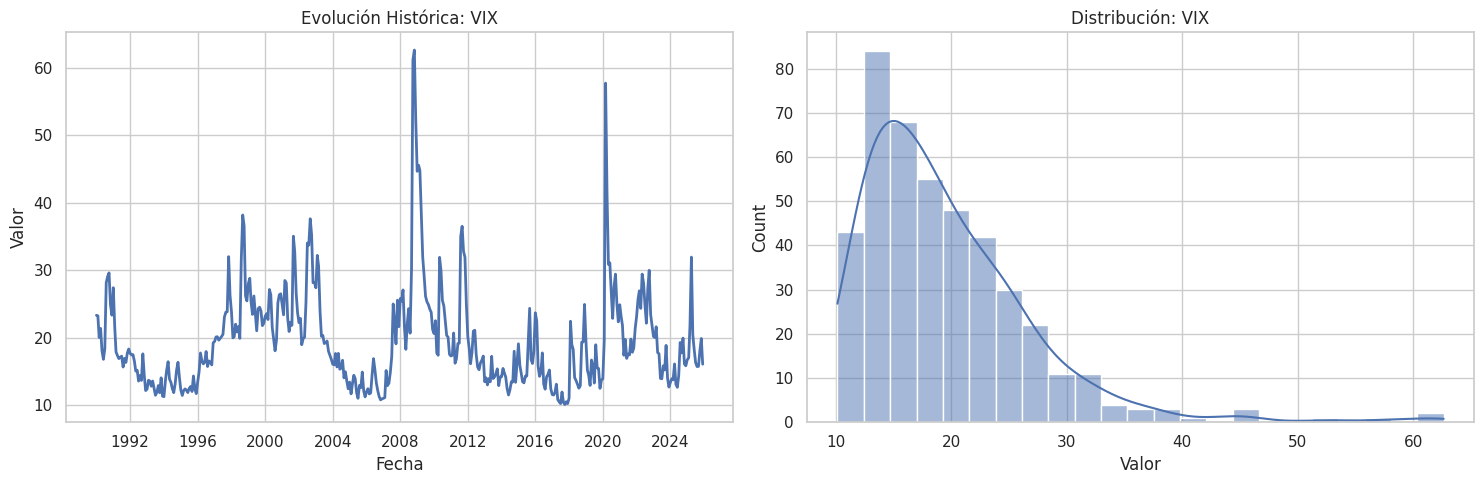

In [27]:

    # EJEMPLO DE AUDITORÍA
    if df_resultado is not None:
        # Descomentar para ver gráficos
        auditar_serie(df_resultado, 'VIX')
        # auditar_serie(df_resultado, 'SP500')

# Economías Emergentes

## EMBI

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Configuración de Estilo
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

def obtener_embi_latam():
    """
    Obtener series de EMBI para LATAM desde GitHub (Excel).
    Países: Argentina, Chile, Brasil, México.

    Fuente: Emerging Markets Bond Index (Embi).xlsx
    Columnas: A (Fecha), B (País), C (EMBI)

    Metodología:
    - Filtrar países.
    - Pivotar tabla.
    - Resampleo mensual: Promedio.
    """
    print("🌎 OBTENIENDO EMBI LATAM (GitHub Excel)")
    print("="*50)

    url = "https://github.com/lucacamus13/Tesis/raw/main/data/Emerging%20Markets%20Bond%20Index%20(Embi).xlsx"

    try:
        print(f"📥 Descargando datos desde: {url}")
        # Leer archivo Excel
        # Asumimos que no tiene header o está en la primera fila.
        # El usuario dijo: A=Fecha, B=País, C=EMBI.
        # Vamos a leer y luego renombrar para asegurar.
        df = pd.read_excel(url)

        # Normalizar nombres de columnas para facilitar búsqueda
        df.columns = [str(col).strip().lower() for col in df.columns]
        print(f"   Columnas encontradas: {df.columns.tolist()}")

        # Identificar columnas
        date_col = df.columns[0] # A
        country_col = df.columns[1] # B
        value_col = df.columns[2] # C

        print(f"   📅 Fecha: {date_col}, 🌍 País: {country_col}, 📈 Valor: {value_col}")

        # Convertir fecha
        df[date_col] = pd.to_datetime(df[date_col])

        # Asegurar valores numéricos
        df[value_col] = pd.to_numeric(df[value_col], errors='coerce')

        # Filtrar Países de interés
        # Normalizamos nombres de países en el excel para coincidir
        target_countries = ['Argentina', 'Chile', 'Brazil', 'Mexico'] # Nombres probables en inglés o español
        # Mapeo de normalización si es necesario

        # Ver qué países hay
        unique_countries = df[country_col].unique()
        print(f"   🌍 Países disponibles en el archivo: {unique_countries}")

        # Filtrar (Búsqueda flexible)
        mask = df[country_col].astype(str).apply(lambda x: any(c.lower() in x.lower() for c in target_countries))
        df_filtered = df[mask].copy()

        # Pivotar: Index=Fecha, Columns=País, Values=EMBI
        df_pivot = df_filtered.pivot_table(index=date_col, columns=country_col, values=value_col)

        # Renombrar columnas para estandarizar
        # Traducir/Limpiar nombres de columnas
        new_cols = {}
        for col in df_pivot.columns:
            col_lower = str(col).lower()
            if 'argentina' in col_lower: new_cols[col] = 'EMBI_Argentina'
            elif 'chile' in col_lower: new_cols[col] = 'EMBI_Chile'
            elif 'brazil' in col_lower or 'brasil' in col_lower: new_cols[col] = 'EMBI_Brasil'
            elif 'mexico' in col_lower: new_cols[col] = 'EMBI_Mexico'

        df_pivot = df_pivot.rename(columns=new_cols)

        # Seleccionar solo las columnas de interés (si se coló alguna otra)
        cols_final = [c for c in df_pivot.columns if 'EMBI_' in c]
        df_pivot = df_pivot[cols_final]

        print(f"   ✅ Datos filtrados y pivotados. {len(df_pivot)} filas diarias.")

        # Resampleo Mensual (Promedio)
        print("   🔄 Mensualizando (Promedio)...")
        df_monthly = df_pivot.resample('MS').mean()

        print(f"   ✅ Procesamiento completado. {len(df_monthly)} observaciones mensuales.")
        print(f"   ℹ️ Rango: {df_monthly.index.min().date()} - {df_monthly.index.max().date()}")

        return df_monthly

    except Exception as e:
        print(f"   ❌ Error procesando EMBI: {e}")
        return None

def auditar_serie(df, nombre_serie):
    """
    Función para auditar visual y estadísticamente una serie específica.
    """
    if df is None or nombre_serie not in df.columns:
        print(f"❌ La serie '{nombre_serie}' no se encuentra en el DataFrame.")
        return

    print(f"\n🔍 AUDITORÍA DE LA SERIE: {nombre_serie}")
    print("="*60)

    serie = df[nombre_serie].dropna()

    print(f"📌 Rango Temporal: {serie.index.min().date()} a {serie.index.max().date()}")
    print(f"📌 Observaciones: {len(serie)}")

    freq = pd.infer_freq(serie.index)
    print(f"📌 Frecuencia detectada: {freq if freq else 'No detectada (Irregular)'}")

    stats = serie.describe()
    print("\n📊 ESTADÍSTICAS DESCRIPTIVAS:")
    print(f"   - Media:   {stats['mean']:.4f}")
    print(f"   - Desvío:  {stats['std']:.4f}")
    print(f"   - Min:     {stats['min']:.4f}")
    print(f"   - Max:     {stats['max']:.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    sns.lineplot(data=serie, ax=axes[0], linewidth=2)
    axes[0].set_title(f"Evolución Histórica: {nombre_serie}")
    sns.histplot(data=serie, kde=True, ax=axes[1])
    axes[1].set_title(f"Distribución: {nombre_serie}")
    plt.tight_layout()
    plt.show()

def main():
    print("🚀 INICIANDO OBTENCIÓN DE EMBI LATAM")

    df_embi = obtener_embi_latam()

    if df_embi is not None:
        print("\n📋 PRIMERAS 5 FILAS:")
        print(df_embi.head())
        return df_embi
    else:
        return None

if __name__ == "__main__":
    df_resultado = main()

    if df_resultado is not None:
        print("\n🔍 SERIES DISPONIBLES PARA AUDITAR:")
        print(df_resultado.columns.tolist())




🚀 INICIANDO OBTENCIÓN DE EMBI LATAM
🌎 OBTENIENDO EMBI LATAM (GitHub Excel)
📥 Descargando datos desde: https://github.com/lucacamus13/Tesis/raw/main/data/Emerging%20Markets%20Bond%20Index%20(Embi).xlsx
   Columnas encontradas: ['date', 'country', 'embi global diversified subindices', 'embi global diversified subindices - 30d_change', 'embi global diversified subindices - 30d_running_av']
   📅 Fecha: date, 🌍 País: country, 📈 Valor: embi global diversified subindices
   🌍 Países disponibles en el archivo: ['Argentina' 'Brazil' 'Chile' 'Colombia' 'Dominican Republic' 'Ecuador'
 'El Salvador' 'Global' 'Latin' 'Mexico' 'Panama' 'Peru' 'RD-Latin'
 'Uruguay' 'Venezuela' 'Guatemala' 'Costa Rica' 'Bolivia' 'Paraguay'
 'Honduras']
   ✅ Datos filtrados y pivotados. 6625 filas diarias.
   🔄 Mensualizando (Promedio)...
   ✅ Procesamiento completado. 219 observaciones mensuales.
   ℹ️ Rango: 2007-10-01 - 2025-12-01

📋 PRIMERAS 5 FILAS:
country     EMBI_Argentina  EMBI_Brasil  EMBI_Chile  EMBI_Mexico



🔍 AUDITORÍA DE LA SERIE: EMBI_Argentina
📌 Rango Temporal: 2007-10-01 a 2025-12-01
📌 Observaciones: 219
📌 Frecuencia detectada: MS

📊 ESTADÍSTICAS DESCRIPTIVAS:
   - Media:   10.9788
   - Desvío:  6.6798
   - Min:     3.3420
   - Max:     37.8967


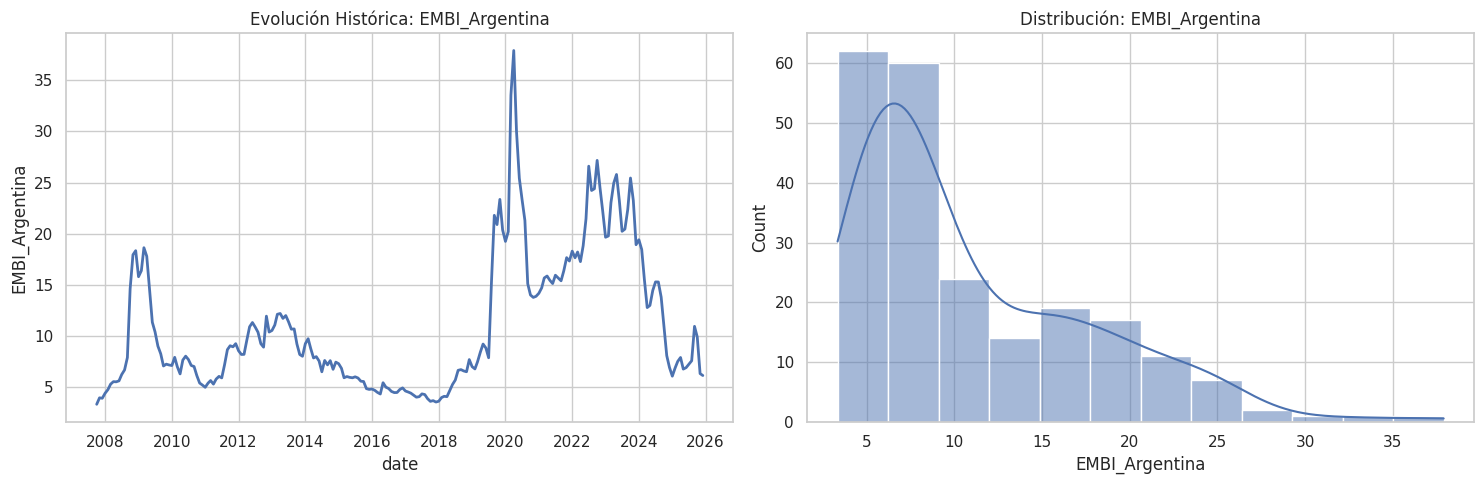

In [42]:

        # -------------------------------------------------------------------------
        # HERRAMIENTA DE AUDITORÍA RÁPIDA
        # -------------------------------------------------------------------------

        # Ejemplo: Argentina (Descomentar otros para ver más)
        if 'EMBI_Argentina' in cols:
            auditar_serie(df_resultado, 'EMBI_Argentina')

        # if 'EMBI_Chile' in cols:
        #     auditar_serie(df_resultado, 'EMBI_Chile')

        # if 'EMBI_Brasil' in cols:
        #     auditar_serie(df_resultado, 'EMBI_Brasil')

        # if 'EMBI_Mexico' in cols:
        #     auditar_serie(df_resultado, 'EMBI_Mexico')


## Actividad

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Configuración de Estilo
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

def procesar_brasil(url):
    """
    Procesar Actividad Económica de Brasil (IBC-Br).
    Formato: Vertical.
    Columna A: Fecha
    Columna B: Índice
    """
    print("\n🇧🇷 PROCESANDO BRASIL...")
    try:
        df = pd.read_excel(url)
        # Asumir A=Fecha, B=Dato (indices 0 y 1)
        df = df.iloc[:, [0, 1]]
        df.columns = ['Fecha', 'Indice']

        df['Fecha'] = pd.to_datetime(df['Fecha'])
        df = df.set_index('Fecha')
        df['Indice'] = pd.to_numeric(df['Indice'], errors='coerce')

        # Transformación: Log-Diff * 100
        df['Actividad_Brasil'] = np.log(df['Indice']).diff() * 100

        print(f"   ✅ {len(df)} observaciones.")
        return df[['Actividad_Brasil']]
    except Exception as e:
        print(f"   ❌ Error Brasil: {e}")
        return None

def procesar_chile(url):
    """
    Procesar Actividad Económica de Chile (Imacec).
    Formato: Vertical.
    Columna A: Fecha
    Columna B: Índice
    """
    print("\n🇨🇱 PROCESANDO CHILE...")
    try:
        df = pd.read_excel(url)
        # Asumir A=Fecha, B=Dato (indices 0 y 1)
        df = df.iloc[:, [0, 1]]
        df.columns = ['Fecha', 'Indice']

        df['Fecha'] = pd.to_datetime(df['Fecha'])
        df = df.set_index('Fecha')
        df['Indice'] = pd.to_numeric(df['Indice'], errors='coerce')

        # Transformación: Log-Diff * 100
        df['Actividad_Chile'] = np.log(df['Indice']).diff() * 100

        print(f"   ✅ {len(df)} observaciones.")
        return df[['Actividad_Chile']]
    except Exception as e:
        print(f"   ❌ Error Chile: {e}")
        return None

def procesar_mexico(url):
    """
    Procesar Actividad Económica de México (IGAE).
    Formato: Horizontal.
    Fila 5 (idx 4): Años
    Fila 6 (idx 5): Meses
    Fila 7 (idx 6): Datos
    Datos empiezan en Columna C (idx 2)
    """
    print("\n🇲🇽 PROCESANDO MEXICO...")
    try:
        # Leer sin header para acceder por índices de fila
        df_raw = pd.read_excel(url, header=None)

        # Extraer filas relevantes
        years = df_raw.iloc[4, 2:]  # Fila 5, desde col C
        months = df_raw.iloc[5, 2:] # Fila 6, desde col C
        values = df_raw.iloc[6, 2:] # Fila 7, desde col C

        # Construir fechas
        dates = []
        data_values = []

        # Mapeo de meses español a número
        meses_map = {
            'Enero': 1, 'Febrero': 2, 'Marzo': 3, 'Abril': 4, 'Mayo': 5, 'Junio': 6,
            'Julio': 7, 'Agosto': 8, 'Septiembre': 9, 'Octubre': 10, 'Noviembre': 11, 'Diciembre': 12,
            'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
            'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
        }

        for y, m, v in zip(years, months, values):
            try:
                # Limpieza básica de año y mes
                y = int(str(y).split('.')[0]) # Quitar decimales si hay

                m_str = str(m).strip().capitalize()
                # Intentar convertir mes numérico o texto
                if m_str.isdigit():
                    m_num = int(m_str)
                else:
                    # Buscar en mapa (o primeros 3 caracteres)
                    m_num = meses_map.get(m_str)
                    if not m_num:
                        # Intentar con 3 letras
                        m_num = meses_map.get(m_str[:3])

                if y and m_num:
                    date = pd.Timestamp(year=y, month=m_num, day=1)
                    dates.append(date)
                    data_values.append(v)
            except:
                continue

        # Crear DataFrame
        df = pd.DataFrame({'Fecha': dates, 'Indice': data_values})
        df = df.set_index('Fecha')
        df['Indice'] = pd.to_numeric(df['Indice'], errors='coerce')

        # Ordenar por fecha
        df = df.sort_index()

        # Transformación: Log-Diff * 100
        df['Actividad_Mexico'] = np.log(df['Indice']).diff() * 100

        print(f"   ✅ {len(df)} observaciones.")
        return df[['Actividad_Mexico']]

    except Exception as e:
        print(f"   ❌ Error Mexico: {e}")
        return None

def auditar_serie(df, nombre_serie):
    if df is None or nombre_serie not in df.columns: return
    print(f"\n🔍 AUDITORÍA: {nombre_serie}")
    serie = df[nombre_serie].dropna()
    print(f"   Rango: {serie.index.min().date()} - {serie.index.max().date()} ({len(serie)} obs)")
    print(f"   Media: {serie.mean():.4f} | Std: {serie.std():.4f} | Min: {serie.min():.4f} | Max: {serie.max():.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.lineplot(data=serie, ax=axes[0]).set_title(f"Evolución: {nombre_serie}")
    sns.histplot(data=serie, kde=True, ax=axes[1]).set_title(f"Distribución: {nombre_serie}")
    plt.tight_layout()
    plt.show()

def procesar_argentina(url):
    """
    Procesar Actividad Económica de Argentina (EMAE).
    Formato: Vertical (Asumido por defecto).
    Columna A: Fecha
    Columna B: Índice
    """
    print("\n🇦🇷 PROCESANDO ARGENTINA...")
    try:
        df = pd.read_excel(url)
        # Asumir A=Fecha, B=Dato
        df = df.iloc[:, [0, 1]]
        df.columns = ['Fecha', 'Indice']

        df['Fecha'] = pd.to_datetime(df['Fecha'])
        df = df.set_index('Fecha')
        df['Indice'] = pd.to_numeric(df['Indice'], errors='coerce')

        # Transformación: Log-Diff * 100
        df['Actividad_Argentina'] = np.log(df['Indice']).diff() * 100

        print(f"   ✅ {len(df)} observaciones.")
        return df[['Actividad_Argentina']]
    except Exception as e:
        print(f"   ❌ Error Argentina: {e}")
        return None

def main():
    print("🚀 OBTENCIÓN DE ACTIVIDAD ECONÓMICA LATAM")
    print("="*50)

    # Base URL
    BASE_URL = "https://github.com/lucacamus13/Tesis/raw/main/data/"

    # Nombres de archivos (Con espacios reemplazados por %20 para la URL)
    FILE_BRASIL    = "ACTIVIDAD%20-%20BRASIL.xls"
    FILE_CHILE     = "ACTIVIDAD%20-%20CHILE.xls"
    FILE_MEXICO    = "ACTIVIDAD%20-%20MEXICO.xls"
    FILE_ARGENTINA = "ACTIVIDAD%20-%20ARGENTINA.xls"

    # Procesar
    df_brasil    = procesar_brasil(BASE_URL + FILE_BRASIL)
    df_chile     = procesar_chile(BASE_URL + FILE_CHILE)
    df_mexico    = procesar_mexico(BASE_URL + FILE_MEXICO)
    df_argentina = procesar_argentina(BASE_URL + FILE_ARGENTINA)

    # Combinar
    dfs = [d for d in [df_brasil, df_chile, df_mexico, df_argentina] if d is not None]

    if dfs:
        df_final = pd.concat(dfs, axis=1)
        print("\n📋 BASE CONSOLIDADA (Actividad Económica):")
        print(df_final.tail())
        return df_final
    else:
        print("\n⚠️ No se procesó ninguna serie.")
        return None

if __name__ == "__main__":
    df_actividad = main()

    if df_actividad is not None:
        print("\n🔍 SERIES DISPONIBLES:")
        cols = df_actividad.columns.tolist()
        print(cols)

        # Auditar ejemplo (Descomentar para ver)
        if 'Actividad_Argentina' in cols:
            auditar_serie(df_actividad, 'Actividad_Argentina')

        # if 'Actividad_Brasil' in cols:
        #     auditar_serie(df_actividad, 'Actividad_Brasil')


🚀 OBTENCIÓN DE ACTIVIDAD ECONÓMICA LATAM

🇧🇷 PROCESANDO BRASIL...
   ❌ Error Brasil: HTTP Error 404: Not Found

🇨🇱 PROCESANDO CHILE...
   ❌ Error Chile: HTTP Error 404: Not Found

🇲🇽 PROCESANDO MEXICO...
   ❌ Error Mexico: HTTP Error 404: Not Found

🇦🇷 PROCESANDO ARGENTINA...
   ❌ Error Argentina: Unknown datetime string format, unable to parse: Período, at position 1

⚠️ No se procesó ninguna serie.
